### This notebook provides the code for diversity audit of collections from TwitterAAE dataset

In [1]:
import csv
import codecs
import re
from tqdm.notebook import tqdm
import numpy as np
import sumy
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import nltk
import random
from lexrank import STOPWORDS, LexRank
from gensim.models import TfidfModel
from scipy.spatial import distance
from rouge import Rouge 

import networkx as nx
import os

In [2]:
# Get twitteraae_all in the TwitterAAE dataset from http://slanglab.cs.umass.edu/TwitterAAE/

tweetsToDialect = {}
hashtags = []
us = 0
threshold = 0.99
with open('./twitteraae_all', encoding="utf8", errors='ignore') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter='\t')
    for row in tqdm(csv_reader):
        probAA = float(row[-4])
        probWh = float(row[-1])
        probOth = float(row[-2]) + float(row[-3])
        if probOth > 0.1:
            continue
        if probAA < threshold and probWh < threshold:
            continue
        
        text = row[-5]
        
        text = re.sub(r"http\S+", "", text)    
        text = text.lower()
        text = text.replace('_', ' ')
        text = text.replace('\n', ' ')
        text = text.replace('\t', ' ')
        text = text.replace('..', '.')
        text = re.sub('[^A-Za-z0-9.!?#@, ]+', '', text)        
        text = text.replace('  ', ' ')
        text = re.sub(r"\@\w+", 'ATMENTION', text)
                
        if probAA >= threshold:
            tweetsToDialect[text] = "AAE"
        elif probWh >= threshold:
            tweetsToDialect[text] = "WH"
        else:
            continue
                
        


In [4]:
LANGUAGE = "english"
from nltk.corpus import stopwords
stopwords = stopwords.words(LANGUAGE)

In [5]:
## Get Word2Vec model from https://fredericgodin.com/research/twitter-word-embeddings/

import gensim
model = gensim.models.KeyedVectors.load_word2vec_format('./models/word2vec_twitter_tokens.bin', binary=True, unicode_errors='ignore')

vocab = model.vocab
len(vocab)

3039345

In [9]:
def aggregate(feats):
    if len(feats) == 0:
        return []
    return np.mean(feats, axis=0)

def getFeature(t):
    words = nltk.word_tokenize(t)
    feat = []
    for word in words:
        if word in stopwords:
            continue
        if word not in vocab:
            continue
        feat.append(model[word])

    feat = aggregate(feat)
    return feat


allFeatures = {}
for t in tqdm(tweets):
    feat = getFeature(t)
    if len(feat) == 0:
        continue
    allFeatures[t] = feat

In [391]:
tweets = list(allFeatures.keys())
print (len(tweets))

aa_T = [t for t in tweets if tweetsToDialect[t]=="AAE" ]
wh_T = [t for t in tweets if tweetsToDialect[t]=="WH" ]
print (len(aa_T), len(wh_T))

random.shuffle(aa_T)
random.shuffle(wh_T)

baseFrac = len(aa_T)/len(tweets)
baseFrac

1156272
100098 1056174


0.0865695960811989

In [436]:
def getDataset(total, f):
    D = list(tweetsToDialect.keys())
    random.shuffle(D)
    return D[:total]

def getDataset2(total):
    random.shuffle(aa_T)
    random.shuffle(wh_T)
    
    n = int(total/2)
    D = aa_T[:n] + wh_T[:n]
    random.shuffle(D)
    return D
    
def sim(x1, x2):
    return 2 - distance.cosine(x1, x2) 

In [527]:
def getBounds(control):
    validation_m, validation_f = [], []
    for t in control:
        if tweetsToDialect[t] == 'AAE':
            validation_f = validation_f + [t]
        else:
            validation_m = validation_m + [t]
            
    simMatrix = ([np.array([sim(allFeatures[e1], allFeatures[e2]) for e1 in validation_m if e1 != e2]) for e2 in control])
    simSum = [np.mean(simMatrix[i]) for i in range(len(simMatrix))]
    fs = np.mean([simSum[i] for i in range(len(simSum)) if tweetsToDialect[control[i]] == 'AAE'])
    ms = np.mean([simSum[i] for i in range(len(simSum)) if not tweetsToDialect[control[i]] == 'AAE'])
    lowerFS, upperMS = fs, ms
    lowerR = fs/(fs+ms)
    lowerD1 = min(fs/ms, ms/fs)

    simMatrix = ([np.array([sim(allFeatures[e1], allFeatures[e2]) for e1 in validation_f if e1 != e2]) for e2 in control])
    simSum = [np.mean(simMatrix[i]) for i in range(len(simMatrix))]
    fs = np.mean([simSum[i] for i in range(len(simSum)) if tweetsToDialect[control[i]] == 'AAE'])
    ms = np.mean([simSum[i] for i in range(len(simSum)) if not tweetsToDialect[control[i]] == 'AAE'])
    upperFS, lowerMS = fs, ms
    upperR = fs/(fs+ms)
    lowerD2 = min(fs/ms, ms/fs)
    
    return lowerFS, lowerMS, upperFS, upperMS
    
# Random control sets
def getRandomControlSet(indices, k=20):
    control = []
    vpartitions = {}
    k2 = int(k/2)
    
    aa_C = [tweets[i] for i in indices if tweetsToDialect[tweets[i]]=="AAE" ]
    wh_C = [tweets[i] for i in indices if tweetsToDialect[tweets[i]]=="WH" ]
    random.shuffle(aa_C)
    random.shuffle(wh_C)
    
    control = aa_C[:k2] + wh_C[:k2]
    lowerFS, lowerMS, upperFS, upperMS = getBounds(control)

    return control, lowerFS, lowerMS, upperFS, upperMS

# Adaptive control sets
def getGoodControlSet(indices, k=20, alpha=1):
    control = []
    vpartitions = {}
    k2 = int(k/2)

    aa_C = [tweets[i] for i in indices if tweetsToDialect[tweets[i]]=="AAE" ]
    wh_C = [tweets[i] for i in indices if tweetsToDialect[tweets[i]]=="WH" ]
    
    control_0 = []
    gamma = []
    for t in aa_C:
        g_aa = [sim(allFeatures[t], allFeatures[t2]) for t2 in aa_C if t != t2]
        g_wh = [sim(allFeatures[t], allFeatures[t2]) for t2 in wh_C if t != t2]
        gamma.append(np.mean(g_aa) - np.mean(g_wh))
        
    gamma = np.array(gamma)
    red_score = np.array([0 for _ in aa_C])
    while len(control_0) < k2:
        choose = np.argmax(gamma - alpha*red_score)
        
        red_score_2 = []
        for i, t in enumerate(aa_C):
            red_score_2.append(max(red_score[i], sim(allFeatures[aa_C[choose]], allFeatures[t])))
            
        red_score = np.array(list(red_score_2))
        gamma[choose] = -100000
        control_0.append(aa_C[choose])
    
        
    control_1 = []
    gamma = []
    for t in wh_C:
        g_aa = [sim(allFeatures[t], allFeatures[t2]) for t2 in aa_C if t != t2]
        g_wh = [sim(allFeatures[t], allFeatures[t2]) for t2 in wh_C if t != t2]
        gamma.append(np.mean(g_wh) - np.mean(g_aa))
        
    gamma = np.array(gamma)
    red_score = np.array([0 for _ in wh_C])
    while len(control_1) < k2:
        choose = np.argmax(gamma - alpha*red_score)
#         print (gamma[choose], red_score[choose])
        
        red_score_2 = []
        for i, t in enumerate(wh_C):
            red_score_2.append(max(red_score[i], sim(allFeatures[wh_C[choose]], allFeatures[t])))
            
        red_score = np.array(list(red_score_2))
        gamma[choose] = -100000
        control_1.append(wh_C[choose])

    control = control_0 + control_1
    
    lowerFS, lowerMS, upperFS, upperMS = getBounds(control)
    return control, lowerFS, lowerMS, upperFS, upperMS


In [586]:
control, lowerFS, lowerMS, upperFS, upperMS = getRandomControlSet(validation, k=50)
print (lowerFS, lowerMS, upperFS, upperMS, len(control))

control, lowerFS, lowerMS, upperFS, upperMS = getGoodControlSet(validation, k=50, alpha=0.1)
print (lowerFS, lowerMS, upperFS, upperMS, len(control))

1.4294318437576294 1.4294318437576294 1.4890627130002214 1.4140237016975883 49
1.3397660568594931 1.3397660568594931 1.4934664133536644 1.3143205307237804 50


In [558]:
## DivScore for collections with same fraction of AAE posts (8.7%) with control sets of different sizes

size = 1000
reps = 25
m = 11
p_size = 500

def eval(dataset, inp):
    control, lowerFS, lowerMS, upperFS, upperMS = inp
    DIs = []
    random.shuffle(control)
    for k in tqdm(range(10, 100, 10)):
        DIs.append(getProxyMeasure(dataset, control[:k], lowerFS, lowerMS, upperFS, upperMS))
    return DIs

sDIsAll_rand, sDIsAll_good = [], []
for _ in tqdm(range(reps)):
    indices = list(range(len(tweets)))
    random.shuffle(indices)

    test, validation = indices[p_size:], indices[:p_size]
    N = int(size*baseFrac)
    aa_T = [tweets[i] for i in test if tweetsToDialect[tweets[i]]=="AAE" ]
    wh_T = [tweets[i] for i in test if tweetsToDialect[tweets[i]]=="WH" ]

    random.shuffle(aa_T)
    random.shuffle(wh_T)
    dataset = []
    dataset += aa_T[:N] + wh_T[:(size-N)]
    random.shuffle(dataset)

    sDIs_r, sDIs_g = [], []
    
    sDIsAll_rand.append(eval(dataset, getRandomControlSet(validation, k=100)))
    sDIsAll_good.append(eval(dataset, getGoodControlSet(validation, k=100, alpha=0.1)))


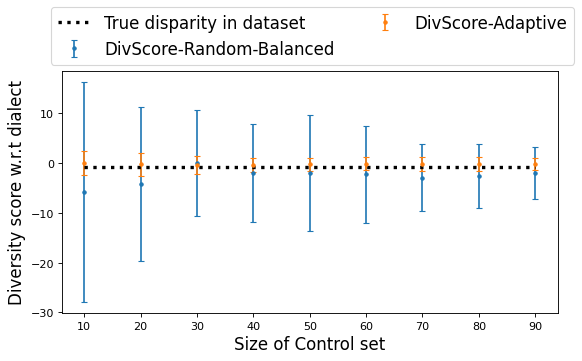

In [560]:
from matplotlib.transforms import Affine2D
figure(num=None, figsize=(8, 4), dpi=80, facecolor='w', edgecolor='k')

yl = 1.5
fs = 15
m2 = 9
xs = list(range(10, 100, 10))
def plot1(DIs, label="", xt=0):
    ys = np.array([np.mean(DIs[:,i]) for i in range(m2)])
    err = np.array([np.std(DIs[:,i]) for i in range(m2)])
    ax.errorbar(xs, ys, err, fmt=".", label=label, capsize=3, capthick=1, markersize=6)
    
ax = plt.subplot(111)
ys = [(2*baseFrac-1) for x in xs]
ax.plot(xs, ys, ":", label="True disparity in dataset", lw=3, color="black")
ax.set_xlabel("Size of Control set", fontsize=fs)
ax.set_ylabel("Diversity score w.r.t dialect", fontsize=fs)
plot1(np.array(sDIsAll_rand), label="DivScore-Random-Balanced",xt=-0.01)
plot1(np.array(sDIsAll_good), label="DivScore-Adaptive",xt=0.01)
ax.legend(fontsize=15, bbox_to_anchor=(1.05,1.3), ncol=2)        


In [584]:
## DivScore for collections with different fraction of AAE posts

size = 1000
reps = 25
m = 11
p_size = 300

def eval(test, inp1, inp2):
    rDIs, gDIs = [], []

    ## dialect audit
    for f in (np.linspace(0, 1, m)):
        
        N = int(size*f)
        aa_T = [tweets[i] for i in test if tweetsToDialect[tweets[i]]=="AAE" ]
        wh_T = [tweets[i] for i in test if tweetsToDialect[tweets[i]]=="WH" ]

        random.shuffle(aa_T)
        random.shuffle(wh_T)
        dataset = []
        dataset += aa_T[:N] + wh_T[:(size-N)]
        random.shuffle(dataset)
        
        control, lowerFS, lowerMS, upperFS, upperMS = inp1
        ds1 = getProxyMeasure(dataset, control, lowerFS, lowerMS, upperFS, upperMS)
        
        control, lowerFS, lowerMS, upperFS, upperMS = inp2
        ds2 = getProxyMeasure(dataset, control, lowerFS, lowerMS, upperFS, upperMS)
        rDIs.append(ds1)
        gDIs.append(ds2)
    return rDIs, gDIs

gDIsAll_rand, gDIsAll_good = [], []
for _ in tqdm(range(reps)):
    indices = list(range(len(tweets)))
    random.shuffle(indices)

    test, validation = indices[p_size:], indices[:p_size]
    rDIs, gDIs = eval(test, getRandomControlSet(validation, k=50), getGoodControlSet(validation, k=50, alpha=0.1))
    gDIsAll_rand.append(rDIs)
    gDIsAll_good.append(gDIs)



50 50
50 50
49 50



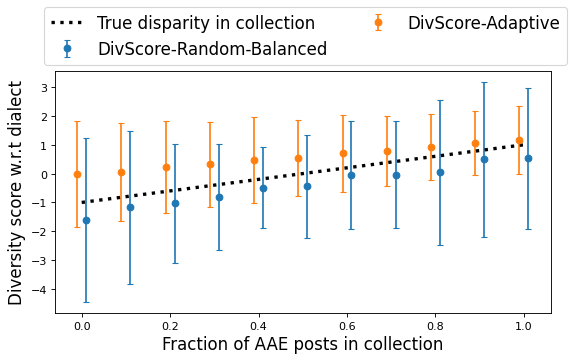

In [585]:
from matplotlib.transforms import Affine2D
figure(num=None, figsize=(8, 4), dpi=80, facecolor='w', edgecolor='k')

yl = 1.5
fs = 15
def plot1(DIs, label="", xt=0):
    ys = np.array([np.mean(DIs[:,i]) for i in range(m)])
    err = np.array([np.std(DIs[:,i]) for i in range(m)])
    xs = np.linspace(0, 1, m)
    trans = Affine2D().translate(-xt, 0.0) + ax.transData
    ax.errorbar(xs, ys, err, fmt="o", label=label, transform=trans, capsize=3, capthick=1, markersize=6)
    
ax = plt.subplot(111)
xs = np.linspace(0, 1, m)
ys = [(2*x-1) for x in xs]
ax.plot(xs, ys, ":", label="True disparity in collection", lw=3, color="black")
ax.set_xlabel("Fraction of AAE posts in collection", fontsize=fs)
ax.set_ylabel("Diversity score w.r.t dialect", fontsize=fs)
# ax.set_ylim([-yl,yl])
plot1(np.array(gDIsAll_rand_3[-25:]), label="DivScore-Random-Balanced",xt=-0.01)
plot1(np.array(gDIsAll_good_3[-25:]), label="DivScore-Adaptive",xt=0.01)
ax.legend(fontsize=15, bbox_to_anchor=(1.05,1.3), ncol=2)        
